### Installing required libraries

In [22]:
%pip install opencv-python mpmath scikit-learn fingerprint_feature_extractor fingerprint_enhancer pycryptodome torch torchvision matplotlib reedsolo unireedsolomon 


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Importing all required libraries

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import fingerprint_feature_extractor as ffx
import fingerprint_enhancer as fe
import numpy as np
import cv2
import os
import sys
import math
import random
import pickle
import mpmath
import copy
import gzip
import inspect
import itertools
from random import randint
import secrets
import hashlib
import json
from math import sin, log10, pow, ceil
import reedsolo
import numpy as np
import os
import cv2
import json
import shutil
import math
import fingerprint_enhancer as fe
from skimage.morphology import skeletonize
import fingerprint_feature_extractor as ffx
from math import ceil, floor, sqrt
from numpy.polynomial.polynomial import polydiv
from unireedsolomon import RSCoder
from Crypto.Cipher import AES 
from os import urandom
from Crypto.Util.Padding import pad
from sys import getsizeof
from time import time
# sklearn based svm ranking
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import os
import reedsolo
import unireedsolomon as urs
from random import randint
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from reedsolo import RSCodec, ReedSolomonError

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50
import numpy as np
import cv2
from time import time
import json

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Generate Iris feature vectors 

In [24]:
def segment_pupil(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, 5)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.5, minDist=gray.shape[0] // 8,
                               param1=50, param2=30, minRadius=10, maxRadius=60)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            return int(x), int(y), int(r)
    
    return None

def segment_iris(image, pupil_x, pupil_y, pupil_r):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    edges = cv2.Canny(blurred, 50, 150)
    
    mask = np.zeros_like(edges)
    cv2.circle(mask, (pupil_x, pupil_y), pupil_r + 10, 255, thickness=-1)
    masked_edges = cv2.bitwise_and(edges, edges, mask=cv2.bitwise_not(mask))

    circles = cv2.HoughCircles(masked_edges, cv2.HOUGH_GRADIENT, dp=1.5, minDist=gray.shape[0] // 8,
                               param1=50, param2=20, minRadius=pupil_r + 20, maxRadius=pupil_r * 4)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            if np.sqrt((x - pupil_x)**2 + (y - pupil_y)**2) < r:
                return int(x), int(y), int(r)
    
    return None

def normalize_iris(image, pupil_x, pupil_y, pupil_r, iris_r, radius=64):
    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.circle(mask, (pupil_x, pupil_y), iris_r, (255, 255, 255), thickness=-1)
    masked_iris = cv2.bitwise_and(image, mask)
    polar_array = cv2.warpPolar(masked_iris, (radius * 2, 360), (pupil_x, pupil_y), iris_r, cv2.WARP_POLAR_LINEAR)
    polar_array = cv2.resize(polar_array, (radius, radius), interpolation=cv2.INTER_AREA)
    return polar_array

def gabor_filter(img, ksize=31, sigma=4.0, theta=0, lambd=10.0, gamma=0.5, psi=0):
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
    filtered_img = cv2.filter2D(img, cv2.CV_8UC3, gabor_kernel)
    return filtered_img

def extract_iris_code(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filtered = gabor_filter(image)
    _, binary_code = cv2.threshold(filtered, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_code = binary_code.flatten()
    
    if len(binary_code) > 2048:
        binary_code = binary_code[:2048]
    elif len(binary_code) < 2048:
        binary_code = np.pad(binary_code, (0, 2048 - len(binary_code)), 'constant')

    assert len(binary_code) == 2048, "Feature vector length is not 2048 bits"

    bit_string = ''.join(str(int(b)) for b in binary_code)
    return bit_string

def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image from {image_path}")
        return None, None
    
    pupil_data = segment_pupil(image)
    if pupil_data:
        pupil_x, pupil_y, pupil_r = pupil_data
        iris_data = segment_iris(image, pupil_x, pupil_y, pupil_r)
        if iris_data:
            iris_x, iris_y, iris_r = iris_data
            normalized_iris = normalize_iris(image, pupil_x, pupil_y, pupil_r, iris_r)
            iris_code = extract_iris_code(normalized_iris)
            return iris_code, normalized_iris
        else:
            print(f"Iris not detected in {image_path}")
            return None, None
    else:
        print(f"Pupil not detected in {image_path}")
        return None, None

def main(dataset_path):
    feature_vectors = {}
    example_segmented_iris = None

    subject_image_count = {}

    # First pass: count the number of left eye images per subject
    # for root, dirs, files in os.walk(dataset_path):
    #     for file in files:
    #         if 'L' in file:  # Count only left eye images
    #             subject_id = os.path.basename(root)
    #             user_id = file[2:5]
    #             if subject_id not in subject_image_count:
    #                 subject_image_count[subject_id] = 0
    #             subject_image_count[subject_id] += 1

    # print(subject_image_count)
    for item in os.listdir(dataset_path):
        for file in os.listdir(f'{dataset_path}/{item}/L'):
            user_id = file[2:5]
            if user_id not in subject_image_count:
                subject_image_count[user_id] = 0
            subject_image_count[user_id] += 1
    # print(subject_image_count)

    for item in os.listdir(dataset_path):
        for file in os.listdir(f'{dataset_path}/{item}/L'):
            user_id = file[2:5]
            iris_code, segmented_iris = process_image(f'{dataset_path}/{item}/L/{file}')
            if iris_code is not None:
                if user_id not in feature_vectors:
                    feature_vectors[user_id] = []
                
                feature_vectors[user_id].append(iris_code)
                
                if example_segmented_iris is None:
                    example_segmented_iris = segmented_iris

    # Second pass: process images for subjects with more than five left eye images
    # for root, dirs, files in os.walk(dataset_path):
    #     subject_id = os.path.basename(root)
    #     if subject_image_count.get(subject_id, 0) > 5:
    #         for file in files:
    #             if 'L' in file:  # Process only left eye images
    #                 image_path = os.path.join(root, file)
                    
    #                 iris_code, segmented_iris = process_image(image_path)
    #                 if iris_code is not None:
    #                     if subject_id not in feature_vectors:
    #                         feature_vectors[subject_id] = []
                        
    #                     feature_vectors[subject_id].append(iris_code)
                        
    #                     if example_segmented_iris is None:
    #                         example_segmented_iris = segmented_iris

    feature_vectors = {k: v for k, v in feature_vectors.items() if len(v) >= 5}

    # Save the feature vectors to a JSON file
    with open('iris_vectors2.json', 'w') as f:
        json.dump(feature_vectors, f, indent=4)  # Use indent=4 for better readability


    with open('iris_vectors2.json', 'r') as f:
        feature_vectors = json.load(f)

# Example usage:
dataset_path = './casia'
main(dataset_path)


{'135': 7, '132': 7, '104': 10, '103': 7, '168': 10, '150': 5, '159': 10, '166': 7, '192': 1, '161': 10, '102': 7, '105': 7, '133': 6, '134': 7, '160': 10, '193': 5, '167': 10, '151': 1, '169': 10, '156': 9, '216': 1, '229': 10, '211': 15, '227': 5, '218': 3, '220': 6, '079': 7, '041': 5, '083': 7, '084': 7, '242': 3, '070': 7, '221': 1, '013': 7, '014': 7, '219': 10, '022': 5, '210': 7, '217': 4, '025': 5, '228': 7, '071': 7, '085': 7, '049': 5, '082': 7, '244': 6, '076': 7, '040': 5, '078': 7, '047': 6, '065': 7, '091': 3, '096': 7, '054': 4, '053': 13, '098': 7, '038': 4, '007': 10, '232': 3, '009': 1, '204': 2, '036': 10, '031': 2, '203': 5, '052': 5, '099': 4, '055': 5, '063': 6, '097': 7, '090': 7, '064': 7, '202': 1, '030': 10, '008': 11, '205': 2, '001': 10, '039': 5, '174': 6, '145': 7, '142': 7, '189': 1, '129': 7, '116': 7, '111': 7, '118': 7, '127': 6, '120': 7, '143': 7, '188': 10, '144': 7, '172': 8, '186': 9, '181': 7, '175': 6, '121': 7, '119': 7, '126': 7, '110': 7, '1

### Generate Fingerprint feature vectors

In [25]:
def show_img(img):
    """display the image using matplotlib"""
    plt.imshow(img, cmap='gray')
########################################################################################################################
def preprocessing(img):
    """returns the enhanced image and thinned image"""
    # find out the segmentation mask
    segmentation_mask = np.empty(img.shape, dtype=float)
    global_threshold = np.var(img, axis=None)*0.1
    block_size = 15
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            local_threshold = np.var(img[i:i+block_size, j:j+block_size])
            if(local_threshold > global_threshold):
                segmentation_mask[i:i+block_size, j:j+block_size] = 255
            else:
                segmentation_mask[i:i+block_size, j:j+block_size] = 0
                
    # segment the image based on the mask
    segmented_image = img.copy()
    double_block_size = block_size * 2
    kernel_open_close = cv2.getStructuringElement(cv2.MORPH_RECT, (double_block_size, double_block_size))
    segmentation_mask = cv2.erode(img, kernel_open_close, iterations=1)
    segmentation_mask = cv2.dilate(img, kernel_open_close, iterations=1)
    segmentation_mask = cv2.dilate(img, kernel_open_close, iterations=1)
    segmentation_mask = cv2.erode(img, kernel_open_close, iterations=1)
    for i in range(segmentation_mask.shape[0]):
        for j in range(segmentation_mask.shape[1]):
            if(segmentation_mask[i][j] == 0):
                segmented_image[i][j] = 255

    # normalize the segmented image
    desired_mean, desired_variance = 128.0, 7500.0
    current_mean, current_variance = np.mean(segmented_image), np.var(segmented_image)
    normalized_image = np.empty(segmented_image.shape)
    for i in range(segmented_image.shape[0]):
        for j in range(segmented_image.shape[1]):
            normalization_value = (math.sqrt((desired_variance * pow((img[i][j] - current_mean), 2))/current_variance))
            if segmented_image[i][j] > current_mean:
                normalized_image[i][j] = desired_mean + normalization_value
            else:
                normalized_image[i][j] = desired_mean + normalization_value
    
    # enhance the normalized image
    enhanced_image = fe.enhance_Fingerprint(normalized_image)
    
    # apply thresholding operation
    ret, binarized_image = cv2.threshold(enhanced_image, 127, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

    # thin the image so that each ridge is one pixel wide
    thinned_image = np.where(skeletonize(enhanced_image/255), 0.0, 1.0)
    return enhanced_image, thinned_image
########################################################################################################################
def compute_line_attributes(pt1, pt2):
    # the euclidean distance will be rounded down to find the XOR 
    euclidean_distance = math.sqrt(math.pow(pt1[0] - pt2[0], 2) + math.pow(pt1[1] - pt2[1], 2))
    euclidean_distance = round(euclidean_distance, 2)
    euclidean_distance = ceil(euclidean_distance)
    # the angle is also rounded down to find the xor 
    if pt1[0] != pt2[0]:
        angle = (pt1[1] - pt2[1])/(pt1[0]-pt2[0])
        angle = ceil(round(angle, 2))
    else:
        angle = float('inf')
    return [euclidean_distance, angle]
########################################################################################################################
def sbox(bytes):
    assert(len(bytes)&1==0)
    """return the values of the bytes from the AES SBOX"""
    Sbox = (0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16)
    sbox_list = []
    ctr = 0
    for i in range(16):
        this_row = []
        for j in range(16):
            this_row.append(hex(Sbox[ctr]))
            ctr += 1
        sbox_list.append(this_row)

    sbox_output = ''
    hex_alpha = {'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15}
    try:
        for i in range(0, len(bytes), 2):
            row = 0
            col = 0
            current_byte = bytes[i:i+2]
            # print(f"{current_byte}")
            if ord(current_byte[0]) >= ord('a') and ord(current_byte[0]) <= ord('f'):
                row = hex_alpha[current_byte[0]]
            else:
                row = int(current_byte[0])
            
            if ord(current_byte[1]) >= ord('a') and ord(current_byte[1]) <= ord('f'):
                col = hex_alpha[current_byte[1]]
            else:
                col = int(current_byte[1])
            sbox_output += sbox_list[row][col][2:]
    except IndexError as e:
        print(f"current_byte: {current_byte}")
    # print(f"key length: {len(sbox_output)}")
    return sbox_output
########################################################################################################################
def expansion_permutation(bytes):
    if len(bytes) >= 128:
        return bytes[:128]
    else:
        return bytes
########################################################################################################################
def get_xored_pts(F_B, F_C, F_D):
    F_bin_xor_B, F_bin_xor_C, F_bin_xor_D  = [], [], []
    for i in range(len(F_B)):
        F_bin_xor_B.append(bin(F_B[i][0] ^ F_B[i][1]))
    F_bin_xor_B_C_D = ''
    for i in range(len(F_bin_xor_B)):
        F_bin_xor_B_C_D += F_bin_xor_B[i][2:]
    F_bin_xor_B_C_D = hex(int(F_bin_xor_B_C_D, 2))[2:]
    try:
        assert(len(F_bin_xor_B_C_D)%2 == 0)
    except Exception as e:
        while len(F_bin_xor_B_C_D) % 2 != 0:
            F_bin_xor_B_C_D = '0' + F_bin_xor_B_C_D
    return F_bin_xor_B_C_D

########################################################################################################################
fb1, fc1, fd1, fb2, fd2, fc2 = [],[],[],[],[],[]
def keygen(img, blockSize=60, core_point_loc=None, delta_point_loc=None):
    """generate the key using minutiae information"""
    # TODO: compare results for blockSize 5, 10, 30, 60
    # need to add code to create the block
    terminations, bifurcations = ffx.extract_minutiae_features(img, spuriousMinutiaeThresh=10, invertImage=False, showResult=False)
    minutiae = []
    for termination in terminations:
        minutiae.append([termination.locX, termination.locY])
    for bifurcation in bifurcations:
        minutiae.append([bifurcation.locX, bifurcation.locY])
    #     print(minutiae)

    # try to divide the image into blocks 
    #     img_clone = t_img.copy()
    #     draw vertical lines
    #     for i in range(0, img_clone.shape[0], blockSize):
    #         cv2.line(img_clone, pt1=(i,0), pt2=(i, img_clone.shape[1]), thickness=1, color=(255,255,255))
    #     draw horizontal lines
    #     for j in range(0, img_clone.shape[1], blockSize):
    #         cv2.line(img_clone, pt1=(0, j), pt2=(img_clone.shape[0], j), thickness=1, color=(255,255,255))

    # the input image is 364x256 pixels
    # the core and delta point only consider the distance 
    # threshold_distance = sqrt(pow(136.5, 2) + pow(96, 2))
    threshold_distance = sqrt(pow(240, 2) + pow(240, 2))

    # this is the distance considering the middle point of the center block 
    # and any edge, in this case, (0,0)
   
    # assert(threshold_distance == 166.87794941213772)

    # find out line attributes between each pair of minutiae points
    # for each pair of minutiae find its euclidean distance and angle
    F_B, F_C, F_D = [], [], []
    for i in range(len(minutiae)):
        for j in range(i+1, len(minutiae)):
            res = compute_line_attributes(minutiae[i], minutiae[j])
            # compute this minutiae pair
            if res[0] <= threshold_distance and res[1] != float('inf'):
                res[1] = int(res[1])
                F_B.append(res)

    # find out the set F_C consisting of distances and angles from the core point
    # the set F_C is only found only for the neighbouring 8 blocks
    # with the core point as the centre
    if core_point_loc is not None:
        for i in range(len(minutiae)):
            # compute line distance and slope using core point
            res = compute_line_attributes(core_point_loc, minutiae[i])
            if res[0] <= threshold_distance and res[1] != float('inf'):
                res[1] = int(res[1])
                F_C.append(res)
    # find out the set F_D consisting of distances and angles from the delta point
    if delta_point_loc is not None:
        for i in range(len(minutiae)):
            # compute the line and angles using delta point
            res = compute_line_attributes(delta_point_loc, minutiae[i])
            if res[0] <= threshold_distance and res[1] != float('inf'):
                res[1] = int(res[1])
                F_D.append(res)
    
    # many angles are negative which will affect binarization
    # so convert all values to positive (not non-negative)
    min_angle_f_b = min(F_B, key=lambda point:point[1])[1]
    min_angle_f_b = abs(min_angle_f_b) + 1
    # increase all angles by this amount
    for i in range(len(F_B)):
        F_B[i][1] += min_angle_f_b
     
    # min_angle_f_c = min(F_C, key=lambda point:point[1])[1]
    # min_angle_f_c = abs(min_angle_f_c) + 1
    # # increase all angles by this amount
    # for i in range(len(F_C)):
    #     F_C[i][1] += min_angle_f_c
    
    # min_angle_f_d = min(F_D, key=lambda point:point[1])[1]
    # min_angle_f_d = abs(min_angle_f_d) + 1
    # # increase all angles by this amount
    # for i in range(len(F_D)):
    #     F_D[i][1] += min_angle_f_d
    
    # the z_max value is the average of the three sets
    # z_max = (len(F_B) + len(F_C) + len(F_D))//3
    z_max = 27
    # print(f"z_max: {z_max}")

    # fill the sets with zeroes if they have less elements
    while len(F_B) < z_max:
        F_B.append([0,0])
    # while len(F_C) < z_max:
    #     F_C.append([0,0])
    # while len(F_D) < z_max:
    #     F_D.append([0,0])

    F_B = F_B[:z_max]
    # F_C = F_C[:z_max]
    # F_D = F_D[:z_max]

    # generate the set F_max needed for codeword generation
    global F_max
    F_max = F_B
    # print(f"F_max: {F_max}")

    F_bin_xor_B_C_D = get_xored_pts(F_B, F_C, F_D)
    return [sbox(F_bin_xor_B_C_D), F_B, F_C, F_D, terminations, bifurcations]
########################################################################################################################
def get_codeword(message):
    # encode the given message pair and return the codeword binary pair
    coder = RSCoder(20,16)
    return [coder.encode(str(message[0])) + coder.encode(str(message[1])), len(coder.encode(str(message[0])))]
########################################################################################################################
def encrypt(msg, secret_key):
    cipher = AES.new(secret_key, AES.MODE_CBC)
    ciphertext = cipher.encrypt(pad(msg.encode('utf-8'), 16))
    return ciphertext
########################################################################################################################
def compute_lr_ad(F_B, F_C, F_D):
    fvb, fvc, fvd = [], [], []
    try:
        # compute line attributes for each set
        for i in range(len(F_B)):
            for j in range(i+1, len(F_B)):
                temp = [0,0]
                assert(F_B[j][0] > 0)
                temp[0] = round(F_B[i][0]/F_B[j][0], 1)
                temp[1] = F_B[i][1] - F_B[j][1]
                fvb.append(temp)
        for i in range(len(F_C)):
            for j in range(i+1, len(F_C)):
                temp = [0,0]
                assert(F_C[j][0] > 0)
                temp[0] = round(F_C[i][0]/F_C[j][0], 1)
                temp[1] = F_C[i][1] - F_C[j][1]
                fvc.append(temp)
        for i in range(len(F_D)):
            for j in range(i+1, len(F_D)):
                temp = [0,0]
                assert(F_D[j][0] > 0)
                temp[0] = round(F_D[i][0]/F_D[j][0], 1)
                temp[1] = F_D[i][1] - F_D[j][1]
                fvd.append(temp)
    except AssertionError as e:
        print('division by zero')
    F1 = fvb + fvc + fvd
    return [F1, len(fvb), len(fvc), len(fvd)]
########################################################################################################################
def generate_score_vectors():
    """compute score vectors for all pairs of fingerprints in the dataset folder"""
    FOLDER = './dataset/'
    files = ['101_1.tif','101_2.tif','102_1.tif','102_2.tif','104_1.tif','104_2.tif','106_1.tif','106_2.tif','108_1.tif','108_2.tif','108_3.tif','108_4.tif','108_5.tif','108_6.tif','108_7.tif','108_8.tif','110_1.tif','110_2.tif']
    print((len(files)*(len(files)-1))/2)
    # files = files[:4]
    # parse both fingerprits and get the sets in a nested for loop
    # order does not matter so n(n-1)/2 pairs will be there
    # score_file = open('scores.json', 'w+')
    scores = []
    save_file = open('scores.json', 'w')
    # clear the file
    save_file.write('')
    for i in range(len(files)-1):
        for j in range(i+1, len(files)):
            print(f'pair i:{i}, j:{j}')
            img1_path = cv2.imread(f'{FOLDER}/{files[i]}', 0)
            img2_path = cv2.imread(f'{FOLDER}/{files[j]}', 0)
            e1, t1 = preprocessing(img1_path)
            e2, t2 = preprocessing(img2_path)
            core1, delta1 = core_point_locs[i], delta_point_locs[i]
            core2, delta2 = core_point_locs[j], delta_point_locs[j]
            unpacker1 = keygen(img=e1, core_point_loc=core1, delta_point_loc=delta1)
            fb1 = unpacker1[1]
            fc1 = unpacker1[2]
            fd1 = unpacker1[3]
            term1 = unpacker1[4]
            bifur1 = unpacker1[5]
            unpacker2 = keygen(img=e2, core_point_loc=core2, delta_point_loc=delta2)
            fb2 = unpacker2[1]
            fc2 = unpacker2[2]
            fd2 = unpacker2[3]
            term2 = unpacker2[4]
            bifur2 = unpacker2[5]
            unpacker3 = compute_lr_ad(fb1, fc1, fd1)
            F1 = unpacker3[0]
            lfb1 = unpacker3[1]
            lfc1 = unpacker3[2]
            lfd1 = unpacker3[3]
            F1.sort()
            unpacker4 = compute_lr_ad(fb2, fc2, fd2)
            F2 = unpacker4[0]
            lfb2 = unpacker4[1]
            lfc2 = unpacker4[2]
            lfd2 = unpacker4[3]
            F2.sort()
            # print([lfb1, lfc1, lfd1], [lfb2, lfc2, lfd2])
            # assert((lfb1 + lfc1 + lfd1) == (lfb2 + lfc2 + lfd2))
            s1, s2, s3 = [0, 0, 0]
            for k in range(lfb1):
                for l in range(lfb2):
                    if F1[k][0] == F2[l][0] and F1[k][1] == F2[l][1]:
                        s1 += 1
            for k in range(lfb1+1, lfc1):
                for l in range(lfb2+1, lfc2):
                    if F1[k][0] == F2[l][0] and F1[k][1] == F2[l][1]:
                        s2 += 1
            for k in range(lfc1+1, lfd1):
                for l in range(lfc2+1, lfd2):
                    if F1[k][0] == F2[l][0] and F1[k][1] == F2[l][1]:
                        s3 += 1
            scores.append([s1, s2, s3])
    save_file.write(json.dumps({0: scores}, indent=4))
    return scores
########################################################################################################################
def fingerprint_ec_perf():
    """ 
        This method was intended to find the error correction performance.  
        But the bit stream is generated using an s-box that randomizes the bit streams.
        Hence, this test is completely useless.
    """
    # image dimensions are 256x364
    # find the vector using only the minutia and then try to correct errors
    cd = [] # stores the number of correctly decoded samples per class
    # run for each of the 10 classes
    sum_len = 0
    rsc = reedsolo.RSCodec(100)
    for i in range(1, 10):
        correct_decodings = []
        print(f'Processing user no. 10{i}...')
        base_str = keygen(cv2.imread(f'./db1_b/10{i}_1.tif', 0))[0]
        base_str = bin(int(base_str, 16))[2:]
        sum_len += len(base_str)
        score = 0 # stores the number of correct decodings per class
        rsc.encode(bytes(base_str, encoding='utf-8'))
        # runs for the rest of the samples
        for j in range(2, 9):
            # get the query biometric vector
            query_str = keygen(cv2.imread(f'./db1_b/10{i}_{j}.tif', 0))[0]
            query_str = bin(int(query_str, 16))[2:]
            # make sure the length of the query_str is same as the base_str
            len_diff = len(base_str) - len(query_str)
            # skip if the query_str has extra characters, there is no way to
            # truncate some characters and make it equal to base_str
            if len_diff > 0:
                # during error correction, the length may not be same
                # so append zeroes to make the strings of same length
                while len_diff:
                    query_str = '0' + query_str
                    len_diff -= 1
            if len_diff == 0:
                # try error correction   
                try:
                    rsc.decode(bytes(query_str, encoding='utf-8'))
                    score += 1
                except reedsolo.ReedSolomonError as rse:
                    # couldnt deocde properly/too many errors
                    print(f'error in decoding ./db1_b/10{i}_{j}.tif')
            correct_decodings.append(score)
    print(f'The number of correct decodings per class: {correct_decodings}')
    print(f'Average length of fingerprint feature vector: {sum_len/80}')
########################################################################################################################

def hamming_distance(bin_str1, bin_str2):
    if len(bin_str1) != len(bin_str2):
        raise ValueError("Both binary strings must be of the same length")

    # Count the number of differing bits
    distance = sum(c1 != c2 for c1, c2 in zip(bin_str1, bin_str2))
    return distance

def minutia_search(i, j, x_minutiae, y_minutiae, x_tol, y_tol):
    """ x_tol and y_tol control how many points to look forward and down """
    for k in range(len(x_minutiae)):
        if (x_minutiae[k]>= i and x_minutiae[k] < i+x_tol) and (y_minutiae[k]>= j and y_minutiae[k] < j+y_tol):
            return True
    return False
    

def generate_feature_vector(img_path, m=64, n=32):
    """ 
        Generate the fingerprint feature vector using the following method:
        1. Divide the image into blocks of size 64 x 32. This gives 2048 boxes.
        2. Iterate over the boxes row by row.
        3. If the box contains at least one minutia, then append '1' to the string.
        4. Else, append a '0' to the string.
        5. Finally output the feature vector.
    """
    img = cv2.imread(img_path, 0)
    e_img, t_img = preprocessing(img)
    terminations, bifurcations = ffx.extract_minutiae_features(img, spuriousMinutiaeThresh=10, invertImage=False, showResult=False)
    minutiae = []
    for termination in terminations:
        minutiae.append([termination.locX, termination.locY])
    for bifurcation in bifurcations:
        minutiae.append([bifurcation.locX, bifurcation.locY])
    x_minutiae = []
    y_minutiae = []
    for _ in minutiae:
        x_minutiae.append(_[0])
        y_minutiae.append(_[1])
    # im = plt.imread(img_path, 0)
    # implot = plt.imshow(im, cmap='gray')
    # plt.scatter(x=x_minutiae, y=y_minutiae, c='y', s=4)
    # used to invert the axis
    # plt.xlim(0, 500)
    # plt.ylim(0, 500)
    # plt.show()
    # Divide the image into 2048 blocks of size 10x15 each
    # To get 2048 blocks
    # Iterate the image row by row
    fingerprint_vector = ''
    for i in range(0, 480, 15):
        for j in range(0, 640, 10):
            has_minutia = minutia_search(i, j, x_minutiae, y_minutiae, x_tol=15, y_tol=10)
            if has_minutia is True:
                fingerprint_vector += ('1')
            else:
                fingerprint_vector += ('0')
    # print(f'Number of blocks traversed: {blocks_trav}')
    # print(f'Extracted fingerprint vector: {fingerprint_vector}')
    # print(f'Extracted fingerprint vector length: {len(fingerprint_vector)}')
    return fingerprint_vector

def generate_feature_vector_mod(img_path, m=26, n=82):
    """ 
       Divide images from db2_b. Image sizes are 364x328.
       Total vector size is expected to be 2132 bits.
    """
    img = cv2.imread(img_path, 0)
    e_img, t_img = preprocessing(img)
    terminations, bifurcations = ffx.extract_minutiae_features(img, spuriousMinutiaeThresh=10, invertImage=False, showResult=False)
    minutiae = []
    for termination in terminations:
        minutiae.append([termination.locX, termination.locY])
    for bifurcation in bifurcations:
        minutiae.append([bifurcation.locX, bifurcation.locY])
    x_minutiae = []
    y_minutiae = []
    for _ in minutiae:
        x_minutiae.append(_[0])
        y_minutiae.append(_[1])
    # im = plt.imread(img_path, 0)
    # implot = plt.imshow(im, cmap='gray')
    # plt.scatter(x=x_minutiae, y=y_minutiae, c='y', s=4)
    # used to invert the axis
    # plt.xlim(0, 500)
    # plt.ylim(0, 500)
    # plt.show()
    # Divide the image into 2048 blocks of size 10x15 each
    # To get 2048 blocks
    # Iterate the image row by row
    fingerprint_vector = ''
    for i in range(0, 364, 14):
        for j in range(0, 328, 4):
            has_minutia = minutia_search(i, j, x_minutiae, y_minutiae, x_tol=15, y_tol=10)
            if has_minutia is True:
                fingerprint_vector += ('1')
            else:
                fingerprint_vector += ('0')
    # print(f'Number of blocks traversed: {blocks_trav}')
    # print(f'Extracted fingerprint vector: {fingerprint_vector}')
    # print(f'Extracted fingerprint vector length: {len(fingerprint_vector)}')
    return fingerprint_vector

def generate_all_vectors():
    """ Generate all biometric vectors and store in a json file """
    if os.path.isfile('fingerprint_vectors.json'):
        # vectors already computed
        return
    vector_dict = dict()
    for i in range(1, 10):
        for j in range(1, 9):
            print(f'Processing ./db1_b/10{i}_{j}.tif...')
            vec = generate_feature_vector(f'./db1_b/10{i}_{j}.tif', 0)
            vector_dict[f'{i}_{j}'] = vec
    with open('fingerprint_vectors.json', 'w') as f:
        json.dump(vector_dict, f)

# generate_all_vectors()
data = dict()
with open(f'fingerprint_vectors.json') as f:
    data = json.load(f)


### Generate Face feature vectors

In [26]:
# load the feature vectors from faces94_data.json
with open('faces94_data.json', 'r') as file:
    data = json.load(file)

### Generating the tokens and computing SHA256 hashes

In [27]:
KEY_SIZE_BYTES = 256
NUM_COMPONENTS = 256

fingerprint_token = secrets.token_hex(KEY_SIZE_BYTES)
face_token = secrets.token_hex(KEY_SIZE_BYTES)
iris_token = secrets.token_hex(KEY_SIZE_BYTES)
fingerprint_hash = hashlib.sha256(fingerprint_token.encode()).hexdigest()
face_hash = hashlib.sha256(face_token.encode()).hexdigest()
iris_hash = hashlib.sha256(iris_token.encode()).hexdigest()

# write to json file, technically these values will be stored in the system
# and compared when the query biometric is presented 
with open('token.json', 'w') as f:
    json.dump({'fingeprint_token': fingerprint_token, 'face_token': face_token, 'iris_token': iris_token}, f)
    
    
def generate_bit_string(size=2048):
    bit_string = ''
    for i in range(size):
        bit_string += str(randint(0, 1))
    return bit_string

# bind the biometric feature values to the cryptographic key
# and generate the helper data
# key components - 32 components with [0-8] range
# bio components - 32 components with [0-127] range
def generate_components(bit_stream, q=NUM_COMPONENTS):
    # partition the continuous bitstream into  q parts
    bit_stream_size=len(bit_stream)
    # print(bit_stream_size)
    bits_per_component = int(bit_stream_size/q)
    print(bits_per_component)
    # print(f'bits per component: {bits_per_component}')
    components = []
    for i in range(0, bit_stream_size, bits_per_component):
        components.append(int(bit_stream[i:i+bits_per_component], 2))
    # print(f'number  of components generated: {len(components)}')
    return components

def char_to_binary(char):
  ascii_value = ord(char)
  binary_string = bin(ascii_value)[2:]  # Remove "0b" prefix
  binary_string = binary_string.zfill(8)
  return binary_string

def get_bin_string(token_string):
    res = ''
    for _ in token_string:
        res += char_to_binary(_)
    return res

### Functions for Key Binding and Key Retrieval

In [28]:
nbd_threshold=40
random_value=40

def generate_components(bit_string, num_components):
    num_bits = len(bit_string)
    bits_per_component = int(num_bits/num_components)
    components = []
    for i in range(0, num_bits, bits_per_component):
        components.append(int(bit_string[i:i+bits_per_component], 2))
    assert(len(components) == num_components)
    return components


def key_binding(bio_components, crypto_components, nbd_threshold=40, random_value=40):
    # bind a 2048 bit key with biometrics
    # randomize the key components
    obj_value = random_value * sin(random_value)
    randomized_components = []
    phi_values = []
    for component in bio_components:
        randomized_components.append(component + (nbd_threshold * random_value))
    bio_mean = sum(bio_components) / len(bio_components)
    for i in range(len(crypto_components)):
        phi_values.append(crypto_components[i]/(bio_mean * obj_value))
    
    return [randomized_components, phi_values]

def key_release(bio_components, hd):
    # release the crypto-components
    def objective_function(bio_component, randomized_value):
        return (1/nbd_threshold) * (bio_component - randomized_value) * sin((1/nbd_threshold) * (bio_component - randomized_value))
    
    obj_value = random_value * sin(random_value)
    bio_mean = sum(bio_components) / len(bio_components)
    retrieved_crypto_components = []
    x_values = []
    for i in range(len(hd[0])):
        x_values.append(objective_function(bio_components[i], hd[0][i]))
    for i in range(len(hd[1])):
        retrieved_crypto_components.append(hd[1][i] * x_values[i] * bio_mean)
    return retrieved_crypto_components

### Reed-Solomon Error Correction

In [29]:
def error_correction(enrol_vector, query_vector, k):
    n = 255
    rs = reedsolo.RSCodec(n - k)
    crypto_key = ''.join(f'{byte:08b}' for byte in  secrets.token_bytes(256))
    crypto_components = generate_components(crypto_key, num_components=256)
    original_list = generate_components(enrol_vector, num_components=256)

    assert(len(original_list) == 256)
    hd = key_binding(original_list, crypto_components)
    # Example data to encode (must be k bytes long)
    comp1 = bytearray(original_list[:k])
    comp2 = bytearray(original_list[k:])
    comp2 += bytearray([0x00] * (k - len(comp2)))
    assert(len(comp2) == k)
    
    # Encode only k components, the rest are redundant symbols
    encoded_data1 = rs.encode(comp1)
    encoded_data2 = rs.encode(comp2)
    corrupted_data1 = encoded_data1[:]
    corrupted_data2 = encoded_data2[:]
    
    query_list = generate_components(query_vector, num_components=256)
    
    compx1 = bytearray(query_list[:k])
    compx2 = bytearray(query_list[k:])
    compx2 += bytearray([0x00] * (k - len(compx2)))
    assert(len(compx2) == k)
    
    # copy the first k query_components into encoded_data which are the corrupted bytes
    for _ in range(k):
        corrupted_data1[_] = compx1[_]
    for _ in range(k):
        corrupted_data2[_] = compx2[_]
    decoded_components1 = rs.decode(corrupted_data1)
    decoded_components2 = rs.decode(corrupted_data2)

    # combine the decoded components to get back the original list
    # the first list has exactly k information symbols
    # the second list has (256 - k) information symbols, rest are zeroes
    # total symbols are 256 components
    corrected_list = list(decoded_components1[0])[:k] + list(decoded_components2[0])[:(256-k)]
    # print(corrected_list)
    assert(corrected_list == original_list)
    return corrected_list

def error_correction_components(enrol_list, query_list, k):
    n = 255
    rs = reedsolo.RSCodec(n - k)
    crypto_key = ''.join(f'{byte:08b}' for byte in  secrets.token_bytes(256))
    crypto_components = generate_components(crypto_key, num_components=256)
    original_list = enrol_list

    assert(len(original_list) == 256)
    hd = key_binding(original_list, crypto_components)
    # Example data to encode (must be k bytes long)
    comp1 = bytearray(original_list[:k])
    comp2 = bytearray(original_list[k:])
    comp2 += bytearray([0x00] * (k - len(comp2)))
    assert(len(comp2) == k)
    
    # Encode only k components, the rest are redundant symbols
    encoded_data1 = rs.encode(comp1)
    encoded_data2 = rs.encode(comp2)
    corrupted_data1 = encoded_data1[:]
    corrupted_data2 = encoded_data2[:]
        
    compx1 = bytearray(query_list[:k])
    compx2 = bytearray(query_list[k:])
    compx2 += bytearray([0x00] * (k - len(compx2)))
    assert(len(compx2) == k)
    
    # copy the first k query_components into encoded_data which are the corrupted bytes
    for _ in range(k):
        corrupted_data1[_] = compx1[_]
    for _ in range(k):
        corrupted_data2[_] = compx2[_]
    decoded_components1 = rs.decode(corrupted_data1)
    decoded_components2 = rs.decode(corrupted_data2)

    # combine the decoded components to get back the original list
    # the first list has exactly k information symbols
    # the second list has (256 - k) information symbols, rest are zeroes
    # total symbols are 256 components
    corrected_list = list(decoded_components1[0])[:k] + list(decoded_components2[0])[:(256-k)]
    # print(corrected_list)
    assert(corrected_list == original_list)
    return corrected_list

def error_correction_dynamic(enrol_vector, query_vector, k):
    n = 255
    rs = reedsolo.RSCodec(n - k)
    crypto_key = ''.join(f'{byte:08b}' for byte in secrets.token_bytes(256))
    crypto_components = generate_components(crypto_key, num_components=256)
    original_list = generate_components(enrol_vector, num_components=256)

    assert len(original_list) == 256
    
    # Partition the original_list into k-sized segments
    segments = [original_list[i:i + k] for i in range(0, len(original_list), k)]
    
    # Pad the last segment with zeros if needed
    if len(segments[-1]) < k:
        segments[-1] += [0x00] * (k - len(segments[-1]))
    
    corrected_list = []
    query_list = generate_components(query_vector, num_components=256)
    query_segments = [query_list[i:i + k] for i in range(0, len(query_list), k)]
    
    if len(query_segments[-1]) < k:
        query_segments[-1] += [0x00] * (k - len(query_segments[-1]))

    for original_segment, query_segment in zip(segments, query_segments):
        comp = bytearray(original_segment)
        encoded_data = rs.encode(comp)
        corrupted_data = encoded_data[:]
        
        for idx in range(k):
            corrupted_data[idx] = query_segment[idx]
        
        decoded_components = rs.decode(corrupted_data)
        corrected_list.extend(list(decoded_components[0])[:k])
    
    # Truncate the corrected list to the original length
    corrected_list = corrected_list[:256]

    assert corrected_list == original_list
    return corrected_list

# Functions generate_components and key_binding are assumed to be defined elsewhere.


def custom_round(n):
    """
    Rounds a number based on the digit immediately after the decimal point.
    If the first digit after the decimal is greater than 5, rounds up.
    If the first digit after the decimal is 5 or less, rounds down.
    
    :param n: The float number to be rounded.
    :return: The rounded integer.
    """
    integer_part = int(n)
    fractional_part = n - integer_part
    first_digit = int(fractional_part * 10)
    
    if first_digit > 5:
        return integer_part + 1
    else:
        return integer_part

### Generate plots for face

Total number of users: 10
[0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.2631578947368421, 0.26842105263157895, 0.2710526315789474, 0.2710526315789474, 0.27368421052631575, 0.27368421052631575, 0.2868421052631579, 0.29210526315789476, 0.2947368421052632, 0.3, 0.30526315789473685, 0.3236842105263158, 0.33157894736842103, 0.3684210526315789, 0.39210526315789473, 0.43684210526315786, 0.46842105263157896, 0.5473684210526315, 0.5947368421052632, 0.6236842105263157, 0.7289473684210526, 0.7973684210526315, 0.9078947368421053, 1.018421052631579, 1.0763157894736843, 1.144736842105263, 1.2342105263157896, 1.35, 1.4421052631578948, 1.5473684210526317, 1.6578947368421053, 1.7947368421052632, 1.8947368421052633, 1.9789473684210528, 2.0736842105263156, 2.181578947368421, 2.3, 2.405263157

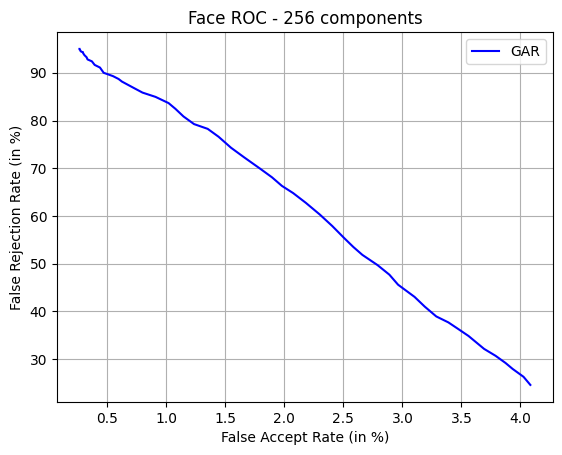

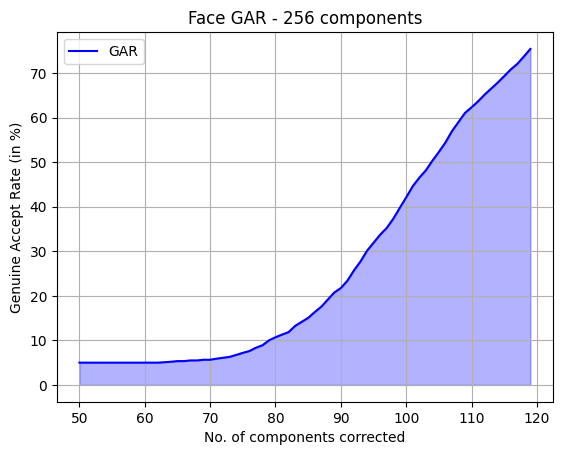

In [30]:
with open('./face_vectors_faces94_male.json') as file:
    data = json.load(file)

data = dict(list(data.items())[:10])

print(f'Total number of users: {len(data)}')

def bits_to_string(bits):
    return ''.join(map(str, bits))

converted_data = {user: [bits_to_string(bits) for bits in bit_lists] for user, bit_lists in data.items()}

real_dict = dict()
user_name = 10
for user, vectors in converted_data.items():
    real_dict[user_name] = vectors
    user_name += 1


with open(f'faces94_data.json', 'w') as json_f:
    json.dump(converted_data, json_f)

def generate_components(bit_string, num_components):
    num_bits = len(bit_string)
    bits_per_component = int(num_bits/num_components)
    components = []
    for i in range(0, num_bits, bits_per_component):
        components.append(int(bit_string[i:i+bits_per_component], 2))
    assert(len(components) == num_components)
    return components


def numerr(comp1, comp2):
    ans = 0
    assert(len(comp1) == len(comp2))
    for i in range(len(comp1)):
        if comp1[i] != comp2[i]:
            ans += 1
    # apply reed solomon error correction on the components
    # try:
    #     error_correction_components(comp1, comp2, ans)
    # except Exception as e:
    #     print(f'{e}: Failed to correct errors')
    return ans

def get_super_dict(nc):
    super_dict = dict()
    for euser, evectors in real_dict.items():
        # print the number of errors for each user compared to each user
        for _ in range(len(evectors)):
            for quser, qvectors in real_dict.items():
                for k in range(len(qvectors)):
                    super_dict[f'{euser}_{_}<>{quser}_{k}'] = numerr(generate_components(real_dict[euser][_], num_components=nc), generate_components(real_dict[quser][k], num_components=nc))
    return super_dict

def calculate_far_frr_gar_grr(super_dict, threshold):
    far = 0
    frr = 0
    gar = 0
    grr = 0
    tot_genuine = 0  # Total genuine attempts
    tot_impostor = 0  # Total impostor attempts

    for key, val in super_dict.items():
        score = val
        u1 = key[:2]
        u2 = key[7:9]
        if u1 == u2:
            tot_genuine += 1
            if score > threshold:
                frr += 1
            else:
                gar += 1
        else:
            tot_impostor += 1
            if score <= threshold:
                far += 1
            else:
                grr += 1
    
    # Calculate percentages
    if tot_genuine > 0:
        gar_percent = (gar / tot_genuine) * 100
        frr_percent = (frr / tot_genuine) * 100
    else:
        gar_percent = frr_percent = 0

    if tot_impostor > 0:
        far_percent = (far / tot_impostor) * 100
        grr_percent = (grr / tot_impostor) * 100
    else:
        far_percent = grr_percent = 0
        
    return far_percent, frr_percent, gar_percent, grr_percent, tot_genuine, tot_impostor

# nc = 64, thresholds = [51, 55, 56, 59]
# nc = 128, thresholds = [85, 90, 95, 110]
# nc = 256, thresholds = [100, 125, 130, 150]
# nc = 512, thresholds = [120, 130, 145, 155]

thresholds = {64: [i for i in range(20, 61)], 128: [i for i in range(40, 100)], 256: [i for i in range(50, 120)], 512: [i for i in range(125, 150)]}

nc = 256

# plot for all component sizes at once
tpr = []
fpr = []
xaxis = []
yaxis = []
xaxis1 = []
yaxis1 = []
super_dict = get_super_dict(nc)
for _ in thresholds[nc]:
    far_percent, frr_percent, gar_percent, grr_percent, tot_genuine, tot_impostor = calculate_far_frr_gar_grr(super_dict, threshold=_)
    tpr.append(gar_percent)
    fpr.append(far_percent)
    xaxis.append(_)
    yaxis.append(gar_percent)
    xaxis1.append(far_percent)
    yaxis1.append(frr_percent)

print(xaxis1)
print(yaxis1)

plt.plot(xaxis1, yaxis1, color='blue', label='GAR')
# plt.fill_between(xaxis, yaxis, alpha=0.3, color='red')
plt.grid(True)
plt.legend()
plt.xlabel('False Accept Rate (in %)')
plt.ylabel('False Rejection Rate (in %)')
plt.title(f'Face ROC - {nc} components')
plt.show()

plt.plot(xaxis, yaxis, color='blue', label='GAR')
plt.fill_between(xaxis, yaxis, alpha=0.3, color='blue')
plt.grid(True)
plt.legend()
plt.xlabel('No. of components corrected')
plt.ylabel('Genuine Accept Rate (in %)')
plt.title(f'Face GAR - {nc} components')
plt.show()


### Generate plots for fingerprint

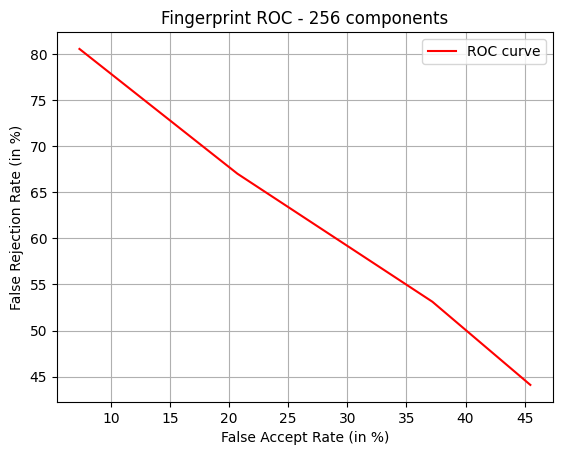

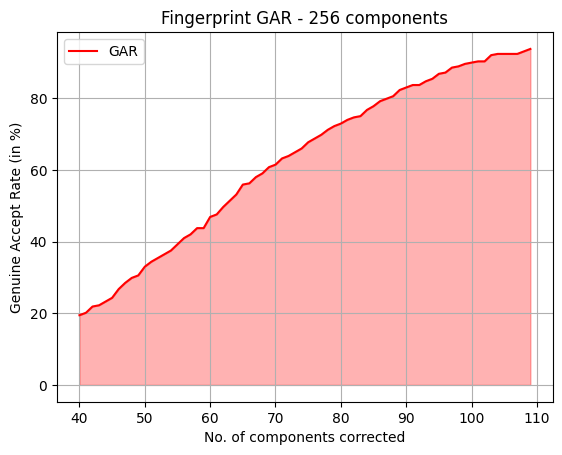

In [43]:
with open('fingerprint_vectors.json') as file:
    data = json.load(file)

# print(f'Total number of users: {len(data)}')

temp_dict = dict()
for inst, vector in data.items():
    user = inst[0]
    if user not in temp_dict:
        temp_dict[user] = []
    temp_dict[user].append(vector)

with open('fingerprint_data.json', 'w') as json_f:
    json.dump(temp_dict, json_f)


def generate_components(bit_string, num_components):
    num_bits = len(bit_string)
    bits_per_component = int(num_bits/num_components)
    components = []
    for i in range(0, num_bits, bits_per_component):
        components.append(int(bit_string[i:i+bits_per_component], 2))
    assert(len(components) == num_components)
    return components

def numerr(comp1, comp2):
    ans = 0
    assert(len(comp1) == len(comp2))
    for i in range(len(comp1)):
        if comp1[i] != comp2[i]:
            ans += 1
    # try:
    #     error_correction_components(comp1, comp2, ans)
    # except Exception as e:
    #     print(f'{e}: Failed to correct errors')
    return ans



def get_super_dict(nc):
    super_dict = dict()
    for euser, evectors in temp_dict.items():
    # print the number of errors for each user compared to each user
        for _ in range(len(evectors)):
            for quser, qvectors in temp_dict.items():
                for k in range(len(qvectors)):
                    super_dict[f'{euser}_{_}<>{quser}_{k}'] = numerr(generate_components(temp_dict[euser][_], num_components=nc), generate_components(temp_dict[quser][k], num_components=nc))
    return super_dict

# nc = 64, thresholds = [20, 25, 40, 45]
# nc = 128, thresholds = [30, 35, 40, 45]
# nc = 256, thresholds = [50, 60, 70, 80]
# nc = 512, thresholds = [85, 95, 105, 115]

def calculate_far_frr_gar_grr(super_dict, threshold):
    far = 0
    frr = 0
    gar = 0
    grr = 0
    tot_genuine = 0  # Total genuine attempts
    tot_impostor = 0  # Total impostor attempts

    for key, val in super_dict.items():
        score = val
        u1 = key[0]
        u2 = key[5]
        if u1 == u2:
            tot_genuine += 1
            if score > threshold:
                frr += 1
            else:
                gar += 1
        else:
            tot_impostor += 1
            if score <= threshold:
                far += 1
            else:
                grr += 1
    
    # Calculate percentages
    if tot_genuine > 0:
        gar_percent = (gar / tot_genuine) * 100
        frr_percent = (frr / tot_genuine) * 100
    else:
        gar_percent = frr_percent = 0

    if tot_impostor > 0:
        far_percent = (far / tot_impostor) * 100
        grr_percent = (grr / tot_impostor) * 100
    else:
        far_percent = grr_percent = 0
        
    return far_percent, frr_percent, gar_percent, grr_percent, tot_genuine, tot_impostor

thresholds = {64: [20, 25, 30, 35], 128: [30, 35, 40, 45], 256: [i for i in range(40, 110)], 512: [i for i in range(80, 120)]}

# plot for all component sizes at once

tpr = []
fpr = []
frr = []
xaxis = []
yaxis = []
xaxis1 = []
yaxis1 = []

nc = 256
ncs = [64, 128, 256]
for _ in thresholds[nc]:
    super_dict = get_super_dict(nc)
    far_percent, frr_percent, gar_percent, grr_percent, tot_genuine, tot_impostor = calculate_far_frr_gar_grr(super_dict, threshold=_)
    tpr.append(gar_percent)
    fpr.append(far_percent)
    frr.append(frr_percent)
    # print(_, [far_percent, frr_percent, gar_percent, grr_percent, tot_genuine, tot_impostor])
    # print(_, far_percent, gar_percent)
    # xaxis.append(far_percent)
    xaxis.append(_)
    yaxis.append(gar_percent)



xaxis1 = []
yaxis1 = []
super_dict = get_super_dict(256)
for _ in [40, 50, 60, 65]:
    far_percent, frr_percent, gar_percent, grr_percent, tot_genuine, tot_impostor = calculate_far_frr_gar_grr(super_dict, threshold=_)
    xaxis1.append(far_percent)
    yaxis1.append(frr_percent)

plt.plot(xaxis1, yaxis1, label='ROC curve', color='red')
plt.grid(True)
plt.legend()
plt.xlabel('False Accept Rate (in %)')
plt.ylabel('False Rejection Rate (in %)')
plt.title(f'Fingerprint ROC - {256} components')
plt.show()


plt.plot(xaxis, yaxis, color='red', label='GAR')
# plt.fill_between(xaxis, yaxis, alpha=0.3, color='red')
plt.grid(True)
plt.legend()
plt.xlabel(f'No. of components corrected')
# plt.xlabel('False Accept Rate (in %)')
plt.ylabel('Genuine Accept Rate (in %)')
plt.fill_between(xaxis, yaxis, alpha=0.3, color='red')
plt.title(f'Fingerprint GAR - {nc} components')
plt.show()

### Generate the plots for iris

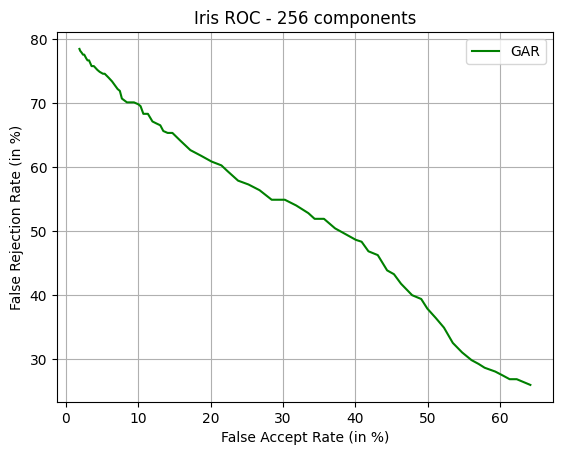

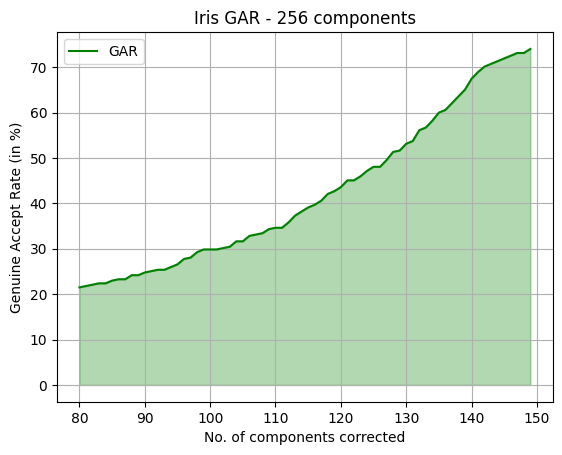

In [44]:
with open('iris_vectors2.json') as file:
    data = json.load(file)

data = dict(list(data.items())[:10])

# print(f'Total number of users: {len(data)}')

def generate_components(bit_string, num_components):
    num_bits = len(bit_string)
    bits_per_component = int(num_bits/num_components)
    components = []
    for i in range(0, num_bits, bits_per_component):
        components.append(int(bit_string[i:i+bits_per_component], 2))
    assert(len(components) == num_components)
    return components

super_dict = dict()

def numerr(comp1, comp2):
    ans = 0
    assert(len(comp1) == len(comp2))
    for i in range(len(comp1)):
        if comp1[i] != comp2[i]:
            ans += 1
    # try:
    #     error_correction_components(comp1, comp2, ans)
    # except Exception as e:
    #     print(f'{e}: Failed to correct errors')
    return ans


nc = 256

for euser, evectors in data.items():
    # print the number of errors for each user compared to each user
    for _ in range(len(evectors)):
        for quser, qvectors in data.items():
            for k in range(len(qvectors)):
                super_dict[f'{euser}_{_}<>{quser}_{k}'] = numerr(generate_components(data[euser][_], num_components=nc), generate_components(data[quser][k], num_components=nc))

def calculate_far_frr_gar_grr(super_dict, threshold):
    far = 0
    frr = 0
    gar = 0
    grr = 0
    tot_genuine = 0  # Total genuine attempts
    tot_impostor = 0  # Total impostor attempts

    for key, val in super_dict.items():
        score = val
        u1 = key[:3]
        u2 = key[7:10]
        if u1 == u2:
            tot_genuine += 1
            if score > threshold:
                frr += 1
            else:
                gar += 1
        else:
            tot_impostor += 1
            if score <= threshold:
                far += 1
            else:
                grr += 1
    
    # Calculate percentages
    if tot_genuine > 0:
        gar_percent = (gar / tot_genuine) * 100
        frr_percent = (frr / tot_genuine) * 100
    else:
        gar_percent = frr_percent = 0

    if tot_impostor > 0:
        far_percent = (far / tot_impostor) * 100
        grr_percent = (grr / tot_impostor) * 100
    else:
        far_percent = grr_percent = 0
        
    return far_percent, frr_percent, gar_percent, grr_percent, tot_genuine, tot_impostor

# nc = 64, thresholds = [35, 45, 55, 62]
# nc = 128, thresholds = [65, 75, 85, 100]
# nc = 256, thresholds = [100, 125, 130, 150]
# nc = 512, thresholds = [175, 185, 190, 200]

thresholds = {64: [i for i in range(20, 61)], 128: [i for i in range(40, 100)], 256: [i for i in range(80, 150)], 512: [i for i in range(175, 200)]}

# plot for all component sizes at once
tpr = []
fpr = []
frr = []
xaxis = []
yaxis = []
xaxis1 = []
yaxis1 = []
for _ in thresholds[256]:
    far_percent, frr_percent, gar_percent, grr_percent, tot_genuine, tot_impostor = calculate_far_frr_gar_grr(super_dict, threshold=_)
    # tpr.append(gar_percent)
    # fpr.append(far_percent)
    # frr.append(frr_percent)
    xaxis.append(_)
    yaxis.append(gar_percent)
    xaxis1.append(far_percent)
    yaxis1.append(frr_percent)
    # print(_, far_percent, frr_percent, gar_percent, grr_percent)

plt.plot(xaxis1, yaxis1, color='green', label='GAR')
# plt.fill_between(xaxis, yaxis, alpha=0.3, color='red')
plt.grid(True)
plt.legend()
plt.xlabel('False Accept Rate (in %)')
plt.ylabel('False Rejection Rate (in %)')
plt.title(f'Iris ROC - {nc} components')
plt.show()

plt.plot(xaxis, yaxis, color='green', label='GAR')
plt.fill_between(xaxis, yaxis, alpha=0.3, color='green')
plt.grid(True)
plt.legend()
plt.xlabel('No. of components corrected')
plt.ylabel('Genuine Accept Rate (in %)')
plt.title(f'Iris GAR - {nc} components')
plt.show()

### Run the overall scheme

In [33]:
def run_scheme(enrol_vectors, query_vectors):
    fingerprint_vector = enrol_vectors[0]
    iris_vector = enrol_vectors[1]
    face_vector = data['3_1']

    NUM_COMP = 256
    KEY_SIZE_BYTES_X = 256

    # generate tokens to bind
    fingerprint_token = secrets.token_hex(KEY_SIZE_BYTES_X)
    face_token = secrets.token_hex(KEY_SIZE_BYTES_X)
    iris_token = secrets.token_hex(KEY_SIZE_BYTES_X)
    fingerprint_hash = hashlib.sha256(fingerprint_token.encode()).hexdigest()
    face_hash = hashlib.sha256(face_token.encode()).hexdigest()
    iris_hash = hashlib.sha256(iris_token.encode()).hexdigest()
    
    # get both the key and bio components 
    fingerprint_key_components = generate_components(get_bin_string(fingerprint_token), q=NUM_COMP)
    face_key_components = generate_components(get_bin_string(face_token), q=NUM_COMP)
    iris_key_components = generate_components(get_bin_string(iris_token), q=NUM_COMP)
    fingerprint_bio_components = generate_components(fingerprint_vector, q=NUM_COMP)
    face_bio_components = generate_components(face_vector, q=NUM_COMP)
    iris_bio_components = generate_components(iris_vector, q=NUM_COMP)

    # generate the helper data
    fingerprint_hd = generate_hd(fingerprint_key_components, fingerprint_bio_components)
    face_hd = generate_hd(face_key_components, face_bio_components)
    iris_hd = generate_hd(iris_key_components, iris_bio_components)
    
    """ 
        Phase - 2: 
        key release - acquiring user biometrics, error correction, verifying stored tokens, generating the key 
    """
    
    # acquire user query biometrics

    # get the query vectors
    fingerprint_vector_q = query_vectors[0]
    iris_vector_q = query_vectors[1]
    face_vector_q = data['3_2']

    # correct the errors
    # takes the original vector and the query vector
    fingerprint_corrected_vector = error_correction_module(fingerprint_vector, fingerprint_vector_q)
    iris_corrected_vector = error_correction_module(iris_vector, iris_vector_q)
    face_corrected_vector = error_correction_module(face_vector, face_vector_q)

    # generate the components
    fingerprint_bio_components_q = generate_components(fingerprint_corrected_vector, q=NUM_COMP)
    face_bio_components_q = generate_components(face_corrected_vector, q=NUM_COMP)
    iris_bio_components_q = generate_components(iris_corrected_vector, q=NUM_COMP)
    
    # verifying stored tokens using query biometrics and stored HD and compare hashes
    verified_biometrics = 0
    try:
        retrieved_key_comp_fingerprint = retrieve_key(fingerprint_hd, fingerprint_corrected_vector)
        retrieved_key_comp_fingerprint_rounded = round_components(retrieved_key_comp_fingerprint)
        if retrieved_key_comp_fingerprint_rounded == fingerprint_key_components:
            verified_biometrics += 1
        else:
            print(f'Retrieved key components: {retrieved_key_comp_fingerprint_rounded}')
            print(f'Original key components: {fingerprint_key_components}')
            print(f'Fingerprint verification failed.')
    except Exception as e:
        print(e)

    try:
        retrieved_key_comp_face = retrieve_key(face_hd, face_corrected_vector)
        retrieved_key_comp_face_rounded = round_components(retrieved_key_comp_face)
        if retrieved_key_comp_face_rounded == face_key_components:
            verified_biometrics += 1
        else:
            print(f'Face verification failed.')
    except Exception as e:
        print(e)

    try:
        retrieved_key_comp_iris = retrieve_key(iris_hd, iris_corrected_vector)
        retrieved_key_comp_iris_rounded = round_components(retrieved_key_comp_iris)
        if retrieved_key_comp_iris_rounded == iris_key_components:
            verified_biometrics += 1
        else:
            print(f'Iris verification failed.')
    except Exception as e:
        print(e)
    
    # if >= 2 biometrics verified, the re-generate the key
    if verified_biometrics >= 2:
        print(f'User verified!!!! Generating the key now...')
    else:
        print(f'User biometric verificaiton failed. Try again please.')

    # decrypt a message
    
    # return success or failure
    return True if verified_biometrics >= 2 else False